## Image Data Preparation:

The data processing is implemented through the LoadImg module (modules/LoadImg.py). The images dataset is first split into train and validation datasets, and then the images size and color mode are adjusted (using keras.preprocessing package). The following code block shows how the train and validation datasets can be obtained via LoadImg module.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from modules import LoadImg
%matplotlib inline

Using TensorFlow backend.


In [2]:
# The color_mode is either 'rgb' or 'grayscale' (default).
X_train, X_validation, y_train, y_validation, cls_indices = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=79, final_img_height=79,
    color_mode="grayscale", random_state=1911)


The image pre-processing is complete.


## Data Exploration:

### Train and Validation Datasets
After data preparation, there are 1315 images in the training dataset and 329 images in the validation dataset.

In [3]:
print('There are {} images in the train dataset.'.format(X_train.shape[0]))
print('There are {} images in the validation dataset.'.format(X_validation.shape[0]))
print('The images shape is {}'.format(X_train.shape[1:]))

There are 1315 images in the train dataset.
There are 329 images in the validation dataset.
The images shape is (79, 79, 3)


In this example, a width and height of 79 were chosen, so the images shape is (79, 79, 3). In the following code blocks, 12 images are randomly selected from train and validation datasets. 

#### Training Data Samples:

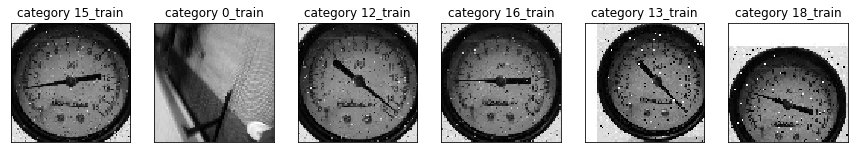

In [4]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train[img_num])))


#### Validation Data Samples:

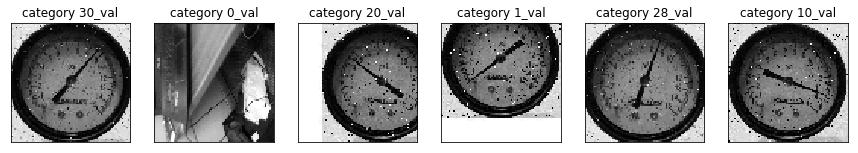

In [ ]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_validation)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_validation[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_val'.format(np.argmax(y_validation[img_num])))

## Ensembling:

The objective of this work is to train multiple models (here, referred to as __primary models__) and eventually use them to construct an ensemble model (a two layer fully connected neural network) which can perform with higher validation accuracy than each individual primary models. To construct the ensemble model, first the primay models are trained and then the logits (i.e. the output of the last layer softmax activation functions) of all models are computed and stacked into a numpy array (1D tensor) which will be the input of the ensemble model, a two layer fully connected neural network. The ensemble model is a classifier that is to predict the same 31 categories. It is trained with the same training dataset and its performance is evaluated versus the same validation dataset as those used for the primary models.

### Primary Models:



For each primary model, a Covolutional Neural Network (CNN) architechture is trained and used for predicting the gauge images categories. There are 30 categories that show the pressure level collected by the gauge with half of the pressure unit (here psi) increments and one NaN category (31 categories all together).

The CNN model consists of three CNN and two Fully Connected (FC) layers (the layers are defined in the NewLayers module, _modules/NewLayers.py_, and are combined in the NeuralNet module, _modules/NeuralNet.py_). The activation function of all layers is Rectified Linear Unit (relu) except the last layer which is softmax.

For training the primary models, the cross-entropy function and Adam algorithm are employed as the cost function and optimizer, respectively. The model performance is evaluated in each training iteration via the accuracy of the validation dataset and the model checkpoint is saved (in the _logs/models/main_ folder) whenever the accuracy is improved. The models that have high validation accuracy for each specific category are also saved (in folders with the same name as the category name like _logs/models/psi_\__2_); these models can be later used as primary models.


### Custom Performance Metric:

The validation dataset accuracy is used as the metric to evaluate the model performance during the model training and the model checkpoint is saved whenever it increases. In tie cases where the performance metric does not change over training iterations, if the median of the true label logits (of the validation dataset) increases, the saved checkpoint is overwritten by the latest model chackpoint.

In addition to the model evaluation using the whole validation dataset accuracy, the model perfomance for each specific category is also evaluated using the following equation:

_catPerf = (number of true predictions in validation dataset for that category)/(total number of validation samples for that category)_

The model checkpoints are also saved whenever the _catPerf_ increases during training in folders corresponding to categories such as _logs/models/psi_\__2_.


### Hyperparameter Tuning:

For the primary models hyperparameter tuning, first a model was trained using images with the same width/height ratio as the original images, which is one here. The hyperparameters of this model were manually tunned and the ones that resulted better performance (i.e. validation dataset accuracy) were used for the subsequent models.


In [ ]:
from modules import OptimizeAndLog

##
OptimizeAndLog.OptimizerLogger. \
    train_and_save_logs_three_CNN(filter_size1=17, num_filters1=45, strides_1=[1, 7, 7, 1],
                                  use_pooling_1=True, pooling_ksize_1=[1, 4, 4, 1], pooling_strides_1=[1, 4, 4, 1],
                                  ##
                                  filter_size2=7, num_filters2=17, strides_2=[1, 5, 5, 1],
                                  use_pooling_2=True, pooling_ksize_2=[1, 3, 3, 1], pooling_strides_2=[1, 3, 3, 1],
                                  ##
                                  filter_size3=1, num_filters3=7, strides_3=[1, 1, 1, 1],
                                  use_pooling_3=False, pooling_ksize_3=None, pooling_strides_3=None,
                                  ##
                                  fc_size=86,
                                  num_iterations=100,
                                  learning_rate=5e-4, momentum=None,
                                  X_train=X_train, y_train=y_train,
                                  X_test=X_validation, y_test=y_validation,
                                  models_log_path='./logs/models/',
                                  cls_indices=cls_indices,
                                  keep_best_model = True,
                                  padding='SAME',
                                  device_name="/cpu:0")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

epoch 0 ... 
train_acc: 0.0259   test_acc: 0.0517  best_logits_median: 0.0324

epoch 1 ... 
train_acc: 0.0433   test_acc: 0.0486  best_logits_median: 0.0324

epoch 2 ... 
train_acc: 0.0943   test_acc: 0.1125  best_logits_median: 0.0319

epoch 3 ... 
train_acc: 0.0867   test_acc: 0.1003  best_logits_median: 0.0319

epoch 4 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 5 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 6 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 7 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 8 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 9 ... 
train_acc: 0.0844   test_acc: 0.1003  best_logits_median: 0.0319

epoch 10 ... 


### Feature Engineering:

For each primary model, the width/height ratios of the images were changed and for each ratio a model was trained and its saved checkpoint was manually copy-pasted to the _logs/historical_\__models_ for the final ensemble model.

In [ ]:
X_train_2, X_validation_2, y_train_2, y_validation_2, _ = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=160, final_img_height=80,
    color_mode="grayscale", random_state=1911)

In [ ]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train_2)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_2[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train_2[img_num])))